# Introduction
We will use a Kalman filter to estimate the state mean $\mu_{t-1}$ and state variance $\sigma_{t-1}^2$ of industry returns at time $t - 1$. To do this, we will use data from $t - 24$ to $t - 1$. Using this information, we will construct a signal for investment at time $t$ of the form
$$
\mu_{t-1} - \frac{\gamma}{2}\sigma_{t-1}^2.
$$
We will suppose $\gamma = 1$ in our calculations. The data were obtained from the Ken French Data Library. We used equally weighted monthly industry returns. The date range is from July 1927 to November 2020.

# Packages and Setup

In [13]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import os
os.chdir('/Users/charlesrambo/Desktop/GitHub data')

In [14]:
# Load equally weighted industry return data
industry = pd.read_csv('10_Industry_Portfolios.csv')

# Convert date column into date-time object
industry['Date'] = pd.to_datetime(industry['Date'], format = '%Y%m') + MonthEnd(0)

# Convert returns to a decimal 
industry.iloc[:, 1:] = industry.iloc[:, 1:].div(100)

industry.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,1926-07-31,0.0116,0.0403,0.0230,-0.0219,0.0221,0.0131,0.0069,0.0245,0.0485,0.0021
1,1926-08-31,0.0500,0.0028,0.0211,0.0441,0.0261,0.0108,-0.0003,0.0611,-0.0200,0.0453
2,1926-09-30,0.0003,-0.0334,0.0053,-0.0351,0.0086,0.0022,-0.0071,0.0080,0.0206,-0.0053
3,1926-10-31,-0.0255,-0.0946,-0.0511,0.0267,-0.0572,-0.0099,-0.0328,0.0013,-0.0298,-0.0251
4,1926-11-30,0.0600,-0.0038,0.0169,0.0159,0.0132,0.0148,0.0135,0.0720,0.0571,0.0085


We will use the EM method of the Kalman filter object to estimate the the parameters of the Kalman filter.

In [15]:
# Record the number of variables
n = 10

# Save identity matrix
I = np.eye(n)

# Define window for Kalman filter
kal_win = 24

# Create data frame to record signal values
kal_mom = pd.DataFrame(index = industry.index[kal_win:], columns = industry.columns)

    
# Create filter
kf = KalmanFilter(initial_state_mean = np.zeros(n),
                initial_state_covariance =  0.10**2 * I,
                transition_matrices = I,
                observation_matrices = I,
                observation_covariance = 0.10**2 * I,
                transition_covariance = I)

# We will loop over the date
dates = np.unique(industry['Date'])[kal_win:]

for date in dates:
    
    # Obtain the end of the signal formation, exclusive
    stop = np.sum(industry['Date'] < date)
    
    # Record the beginning of signal, inclusive
    start = stop - kal_win
    
    # Get 'measurement' values for Kalman filter
    X = np.array(industry.iloc[start:stop, 1:])
    
    try:
        
        kf = kf.em(X, n_iter = 5)
        mu, sigma = kf.smooth(X)
    
    except:
        
        # If det(X'X) is too small for Kalman filter, use 0 as state estimates
        mu, sigma = [np.zeros(n)], [np.zeros((10, 10))]
    
    # Record date for later merger
    kal_mom.loc[stop, 'Date'] = date    
    
    # Record signal
    kal_mom.loc[stop, industry.columns[1:]] = mu[-1] - 0.5 * np.diag(sigma[-1])
    
kal_mom.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
24,1928-07-31T00:00:00.000000000,-0.0421504,-0.0572317,-0.040927,-0.0389522,-0.00291236,-0.0271064,-0.020772,0.00847209,-0.0153193,-0.0243308
25,1928-08-31T00:00:00.000000000,-0.0103538,-0.0198692,-0.0110419,-0.0100597,0.00318983,-0.00996548,0.0149231,0.000487365,-0.00770926,-0.0130317
26,1928-09-30T00:00:00.000000000,0.0115828,0.0418358,0.0294169,0.0114599,0.0265206,0.01071,0.0468245,0.0457265,0.029386,0.0165503
27,1928-10-31T00:00:00.000000000,0.0280554,0.0659232,0.058306,0.0475909,0.0446419,0.00904229,0.0410989,0.0313661,0.0325071,0.0275106
28,1928-11-30T00:00:00.000000000,0.0207193,0.0161748,0.0272953,0.00287588,0.00982882,0.0133701,0.0307457,0.0128617,0.0107958,-0.000600111


All that is left is a little data wrangling.

In [16]:
# Change structure of data frame so industries are observations
kal_mom = pd.melt(kal_mom, id_vars = ['Date'], value_vars = kal_mom.columns[1:])

# Change column names
kal_mom.columns = ['Date', 'Industry', 'Kal_mom']

kal_mom.head()

,Date,Industry,Kal_mom
0,1928-07-31,NoDur,-0.0421504
1,1928-08-31,NoDur,-0.0103538
2,1928-09-30,NoDur,0.0115828
3,1928-10-31,NoDur,0.0280554
4,1928-11-30,NoDur,0.0207193


In [17]:
# Change structure of data frame so industries are observations
industry = pd.melt(industry, id_vars = ['Date'], value_vars = industry.columns[1:])

# Change column names
industry.columns = ['Date', 'Industry', 'Ret']

industry.head()

,Date,Industry,Ret
0,1926-07-31,NoDur,0.0116
1,1926-08-31,NoDur,0.0500
2,1926-09-30,NoDur,0.0003
3,1926-10-31,NoDur,-0.0255
4,1926-11-30,NoDur,0.0600


In [18]:
# Perform merge
df = industry.merge(kal_mom, on = ['Date', 'Industry'])

# Calculate quintiles
df['Quintile'] = df[['Date', 'Kal_mom']].groupby('Date')['Kal_mom'].transform(lambda x: pd.qcut(x, 5, labels = False))

# Add 1 to quintile to avoid confusion
df['Quintile'] = 1 + df['Quintile']

# Drop columns that have done their jobs
df.drop(['Kal_mom', 'Industry'], axis = 1, inplace = True)

df.head()

,Date,Ret,Quintile
0,1928-07-31,0.0016,1
1,1928-08-31,0.0478,2
2,1928-09-30,0.0297,2
3,1928-10-31,0.0312,2
4,1928-11-30,0.0855,4


In [19]:
# Calculate equally weighted returns for each quintile
result = df.groupby(['Date', 'Quintile'])['Ret'].mean().reset_index()

# Make each quintile its own column
result = result.pivot(index = 'Date', columns = 'Quintile', values = 'Ret').reset_index()

# Calculate winners minus losers
result['WML'] = result[5] - result[1]

result.head()

Quintile,Date,1,2,3,4,5,WML
0,1928-07-31,0.00175,0.00970,-0.00550,0.01075,-0.00320,-0.00495
1,1928-08-31,0.07455,0.06175,0.01655,0.07550,0.06585,-0.00870
2,1928-09-30,0.04025,0.02910,0.04085,0.07620,0.01610,-0.02415
3,1928-10-31,0.03770,0.01685,0.01115,0.02060,0.00895,-0.02875
4,1928-11-30,0.12655,0.16225,0.06200,0.10175,0.11665,-0.00990


# Results

In [20]:
# Create data frame for return statistics
stats = pd.DataFrame(index = result.columns[1:])

# Take a look at the mean
stats['mean'] = 12 * result.mean()

# Take a look at the sd
stats['sd'] = np.sqrt(12) * result.std()

# Take a look at the skew
stats['skew'] = 12**(3/2) * result.skew()

stats

,mean,sd,skew
Quintile,,,
1,0.071088,0.275757,43.817036
2,0.133609,0.257241,53.898187
3,0.140479,0.245344,36.941024
4,0.171961,0.247741,54.308307
5,0.220349,0.252025,40.331450
WML,0.149260,0.186653,-39.971048


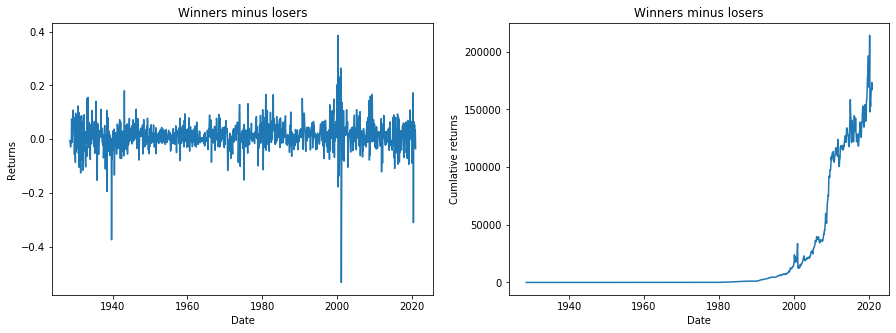

In [21]:
# Plot returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(result['Date'], result['WML'])
ax1.set_xlabel('Date') 
ax1.set_ylabel('Returns') 
ax1.set_title('Winners minus losers') 

ax2.plot(result['Date'], (1 + result['WML']).cumprod() - 1) 
ax2.set_xlabel('Date') 
ax2.set_ylabel('Cumlative returns') 
ax2.set_title('Winners minus losers') 

plt.show()